## Modelado v3 sobre dataset de entregas de actividades

En este notebook, vamos a partir ya de los datasets que mejor han funcionado en la anterior fase para dividirlos en entrenamiento validación y evaluación, y además probar la optimización de hiperparámetros sobre los modelos XGBoost y NN. Se entrenará y validará con StratifiedKfold cross validation, se guardarán los modelos y se evaluarán posteriormente sobre el conjunto de evaluación. 

## Configuración e imports

In [42]:

import joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict, cross_validate
      
)


from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



SEED       = 42                       # determinismo
DATA_PATH  = "/home/carlos/Documentos/TFG/spark-workspace/data/datasets/dataset_1.1.parquet"
RESULTS    = Path("results/models")
RESULTS.mkdir(exist_ok=True, parents=True)
N_JOBS     = -1                       # usa todos los cores
SCORING    = "f1"                     # métrica objetivo de la búsqueda


## Carga de datos y división 

In [43]:
## Split 80 20 
df = pd.read_parquet(DATA_PATH)   
X  = df.drop(columns=["userid", "abandona"])
y  = df["abandona"]

display(X.head())

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train+val: {X_tr.shape},  Test: {X_te.shape}")


,Test Expr.,Test Complejidad,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,Act. 05 - Vectores,Act. 07,num_entregas
0,1,1,1,1,1,0,1,6
1,1,1,1,1,1,1,1,7
2,1,1,1,1,1,1,1,7
3,1,1,1,1,1,1,1,7
4,1,1,1,1,0,1,1,6


Train+val: (160, 8),  Test: (41, 8)


## Función que encapsula la construcción de la arquitectura de la NN

In [44]:
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

## Definición de preprocesamiento y función de construcción de pipelines

In [47]:
# --- Preprocesador único: escala num_entregas, pasa el resto sin cambios ---
preprocessor = ColumnTransformer(
    [("scale_num_entregas", StandardScaler(), ["num_entregas"])],
    remainder="passthrough",
)

def make_pipeline(name: str, use_smote: bool, *, seed: int = SEED):
      """Devuelve un pipeline (pre -> [smote] -> clf)."""
      steps = [("pre", preprocessor)]
      
      if use_smote:
            steps.append(("smote", SMOTE(random_state=seed)))

      if name == "XGB":
            clf = XGBClassifier(  # Estos valores serán modificados durante la busqueda posterior de hiperparámetros
                  n_estimators=200,
                  max_depth=4,
                  learning_rate=0.05,
                  subsample=0.8,
                  colsample_bytree=0.8,
                  eval_metric="logloss",
                  scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
                  random_state=SEED
            )
      elif name == "NN":  # Estos igual 
            ratio = y.value_counts()[0] / y.value_counts()[1]
            clf = KerasClassifier(
                  model=build_model,
                  epochs=60,
                  batch_size=16,
                  verbose=0,
                  fit__class_weight={0: 1, 1: ratio},
                  random_state=SEED
            )
      elif name == "LogReg":
            clf = LogisticRegression(
                  class_weight="balanced",
                  max_iter=1000,
                  random_state=SEED
            )
      elif name == "Tree":
            clf = DecisionTreeClassifier(
                  class_weight="balanced",
                  random_state=SEED
            )
      else:
            raise ValueError(f"Modelo desconocido: {name}")

      steps.append(("clf", clf))
      # Usa ImbPipeline si incluyes SMOTE; sino, Pipeline normal
      Pipe = ImbPipeline if use_smote else Pipeline
      return Pipe(steps, verbose=False)


## Definición de función de búsqueda de hiperparámetros

In [52]:

param_dist_xgb = {
    "clf__n_estimators"     : randint(150, 800),
    "clf__max_depth"        : randint(2, 10),
    "clf__learning_rate"    : uniform(0.01, 0.25),
    "clf__subsample"        : uniform(0.5, 0.5),
    "clf__colsample_bytree" : uniform(0.5, 0.5),
    "clf__gamma"            : uniform(0, 5),
    "clf__min_child_weight" : randint(1, 12),
}

param_dist_nn = {
    # suponiendo paso 'nn' (= KerasClassifier vía scikeras)
    "clf__model__units"          : randint(32, 256),
    "clf__model__dr"             : uniform(0.1, 0.4),
    "clf__optimizer__learning_rate": loguniform(1e-4, 1e-2),
    "clf__epochs"                : randint(40, 120),
    "clf__batch_size"            : [8, 16, 32],
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def tune(model_name, use_smote, param_dist, n_iter=40):
    pipe = make_pipeline(model_name, use_smote)
    search = RandomizedSearchCV(
        pipe, param_distributions=param_dist,
        n_iter=n_iter, scoring=SCORING, cv=cv_inner,
        n_jobs=N_JOBS, verbose=0, random_state=SEED,
        refit=False            # <——
    )
    search.fit(X_tr, y_tr)
    print(f"▶ {model_name}{'+SMOTE' if use_smote else ''}  mejor {SCORING}: {search.best_score_:.3f}")
    return search.best_params_   # <—— devolvemos solo los HP óptimos

## Búsqueda sobre XGB y NN (CV interna)

In [53]:
best_params_xgb  = tune("XGB", False,  param_dist_xgb, n_iter=60)
best_params_nn   = tune("NN" , False,  param_dist_nn , n_iter=30)

best_params_xgb_smote  = tune("XGB", True,  param_dist_xgb, n_iter=60)
best_params_nn_smote   = tune("NN" , True,  param_dist_nn , n_iter=30)

# Reconstruimos pipelines con esos parámetros
xgb_pipe = make_pipeline("XGB", False).set_params(**best_params_xgb)
nn_pipe  = make_pipeline("NN" , False).set_params(**best_params_nn)

xgb_pipe_smote = make_pipeline("XGB", True).set_params(**best_params_xgb)
nn_pipe_smote  = make_pipeline("NN" , True).set_params(**best_params_nn)


▶ XGB  mejor f1: 0.624


2025-06-25 17:40:45.896747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 17:40:45.898796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 17:40:45.903586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 17:40:45.918297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 17:40:45.920746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different 

▶ NN  mejor f1: 0.630
▶ XGB+SMOTE  mejor f1: 0.569


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

▶ NN+SMOTE  mejor f1: 0.567


## Validación cruzada externa para todos los modelos  

In [54]:
scoring = ["f1", "roc_auc", "precision", "recall"]


cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

models = {
      "XGB+SMOTE": xgb_pipe_smote,
      "NN+SMOTE" : nn_pipe_smote,
      "LogReg+SMOTE": make_pipeline("LogReg", True),
      "Tree+SMOTE"  : make_pipeline("Tree" , True),
      "XGB": xgb_pipe,
      "NN" : nn_pipe,
      "LogReg": make_pipeline("LogReg", False),
      "Tree"  : make_pipeline("Tree" , False),
}

val_scores = {}
for name, mdl in models.items():
    scores = cross_validate(
        mdl, X_tr, y_tr, cv=cv_outer, scoring=scoring, n_jobs=N_JOBS
    )
    val_scores[name] = {m: scores[f"test_{m}"].mean() for m in scoring}
pd.DataFrame(val_scores).T.sort_values("f1", ascending=False)


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

,f1,roc_auc,precision,recall
LogReg,0.630468,0.840584,0.535714,0.806667
NN,0.630468,0.846111,0.535714,0.806667
XGB,0.623932,0.819444,0.529304,0.806667
LogReg+SMOTE,0.580118,0.837422,0.502381,0.726667
Tree,0.526940,0.695427,0.452778,0.653333
XGB+SMOTE,0.493651,0.821325,0.392179,0.766667
NN+SMOTE,0.488050,0.817963,0.368131,0.806667
Tree+SMOTE,0.383736,0.647422,0.595000,0.353333


## Entrenamiento final de los modelos sobre el training set 


In [55]:
trained = {}
for name, mdl in models.items():
    mdl.fit(X_tr, y_tr)                    # ahora sí: sobre todo el 80 %
    joblib.dump(mdl, RESULTS / f"{name}.pkl")
    trained[name] = mdl


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-25 17:50:45.660768: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binar

## Evaluación sobre test set

In [56]:
metrics = {}
for name, mdl in models.items():
    y_prob = mdl.predict_proba(X_te)[:,1]
    y_pred = (y_prob >= 0.50).astype(int)
    metrics[name] = {
        "f1"       : f1_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred),
        "recall"   : recall_score(y_te, y_pred),
        "roc_auc"  : roc_auc_score(y_te, y_prob)
    }

pd.DataFrame(metrics).T.sort_values("f1", ascending=False)


2025-06-25 17:51:07.332596: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


,f1,precision,recall,roc_auc
XGB,0.571429,0.428571,0.857143,0.880252
XGB+SMOTE,0.545455,0.400000,0.857143,0.792017
Tree,0.526316,0.416667,0.714286,0.682773
LogReg+SMOTE,0.526316,0.416667,0.714286,0.880252
NN,0.500000,0.384615,0.714286,0.859244
LogReg,0.500000,0.384615,0.714286,0.884454
NN+SMOTE,0.476190,0.357143,0.714286,0.674370
Tree+SMOTE,0.461538,0.500000,0.428571,0.659664


## Exploraciones 

### Coeficientes y odds_ratio de la LR

In [57]:
print("Coeficientes y odds_ratio del modelo de regresión logística con Smote: \n")

# Logistic Regression  ➜ coeficientes y odds-ratio
logreg = models["LogReg+SMOTE"]
coef_df = (
    pd.DataFrame({
        "feature": logreg.named_steps["pre"].get_feature_names_out(),
        "beta"   : logreg.named_steps["clf"].coef_[0]
    })
      .assign(odds_ratio=lambda d: np.exp(d.beta))
      .sort_values("beta", key=np.abs, ascending=False)
)
display(coef_df.head(15))

print("Coeficientes y odds_ratio del modelo de regresión logística sin Smote: \n")

# Logistic Regression  ➜ coeficientes y odds-ratio
logreg = models["LogReg"]
coef_df = (
    pd.DataFrame({
        "feature": logreg.named_steps["pre"].get_feature_names_out(),
        "beta"   : logreg.named_steps["clf"].coef_[0]
    })
      .assign(odds_ratio=lambda d: np.exp(d.beta))
      .sort_values("beta", key=np.abs, ascending=False)
)
display(coef_df.head(15))

Coeficientes y odds_ratio del modelo de regresión logística con Smote: 



,feature,beta,odds_ratio
2,remainder__Test Complejidad,1.958699,7.090096
7,remainder__Act. 07,-1.825507,0.161136
0,scale_num_entregas__num_entregas,-0.814449,0.442883
3,remainder__Act. 02 - Elecciones,-0.753122,0.470894
4,remainder__Act. 03 - Catalan,-0.669914,0.511753
1,remainder__Test Expr.,-0.286762,0.750691
6,remainder__Act. 05 - Vectores,-0.039270,0.961491
5,remainder__Act. 04 - Primos,-0.008227,0.991806


Coeficientes y odds_ratio del modelo de regresión logística sin Smote: 



,feature,beta,odds_ratio
2,remainder__Test Complejidad,1.610512,5.005374
7,remainder__Act. 07,-1.568331,0.208393
0,scale_num_entregas__num_entregas,-0.708865,0.492202
4,remainder__Act. 03 - Catalan,-0.496741,0.608510
1,remainder__Test Expr.,-0.481561,0.617818
3,remainder__Act. 02 - Elecciones,-0.438188,0.645205
6,remainder__Act. 05 - Vectores,-0.107589,0.897996
5,remainder__Act. 04 - Primos,0.043233,1.044181


### Estructura del arbol de decisión

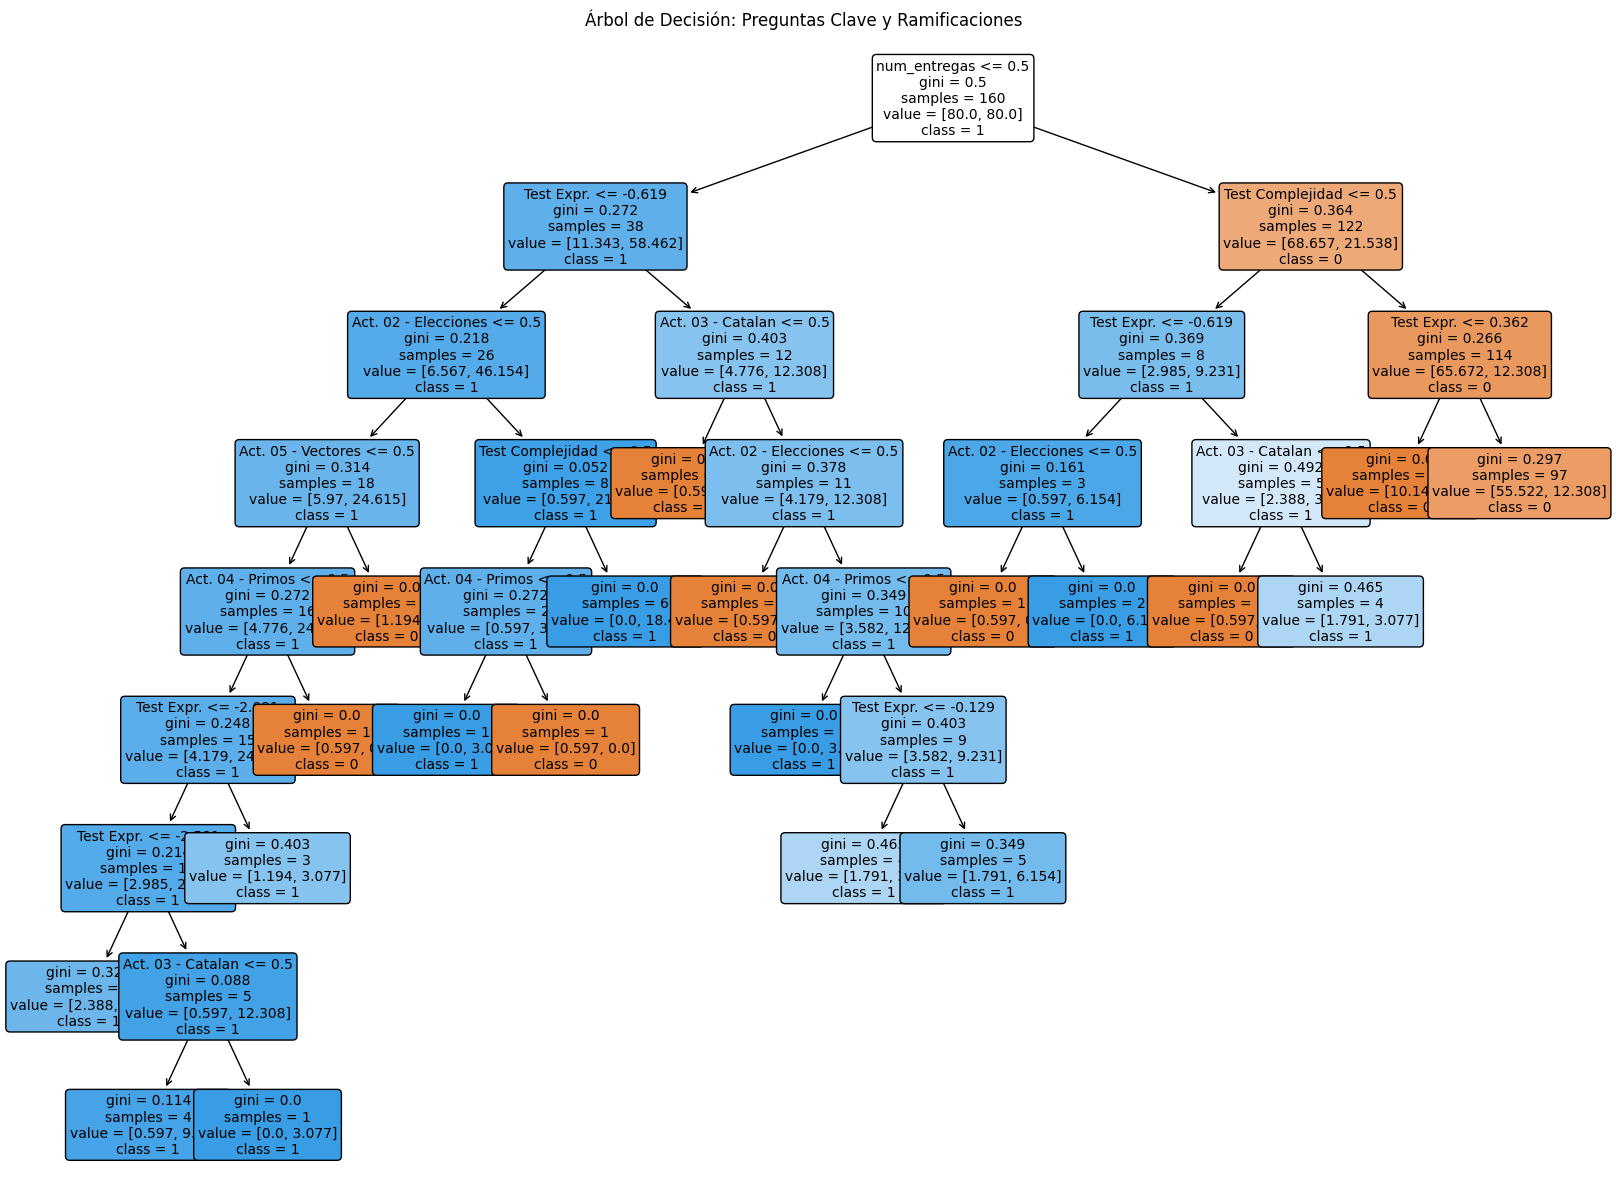

In [58]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Asume que 'models["Tree"].named_steps["clf"]' es tu modelo de árbol de decisión ya entrenado
# y 'X.columns' son los nombres de tus características.

plt.figure(figsize=(20, 15)) # Ajusta el tamaño para que sea legible
plot_tree(
    models["Tree"].named_steps["clf"],
    feature_names=list(X.columns),
    class_names=[str(c) for c in models["Tree"].named_steps["clf"].classes_], # Asegúrate de que sean los nombres de tus clases
    filled=True, # Rellena los nodos con colores para las clases
    rounded=True, # Bordes redondeados para los nodos
    proportion=False, # Muestra el número de muestras en cada nodo
    fontsize=10 # Ajusta el tamaño de la fuente si es necesario
)
plt.title("Árbol de Decisión: Preguntas Clave y Ramificaciones")
plt.show()

# Opcional: Si quieres guardar la imagen
# plt.savefig("arbol_decision_visual.png", dpi=300, bbox_inches="tight")

## Exploración de curva PR, decisión de umbral y matriz de confusión sobre el mejor modelo


▶ Mejor modelo: XGB  –  threshold óptimo ≈ 0.619


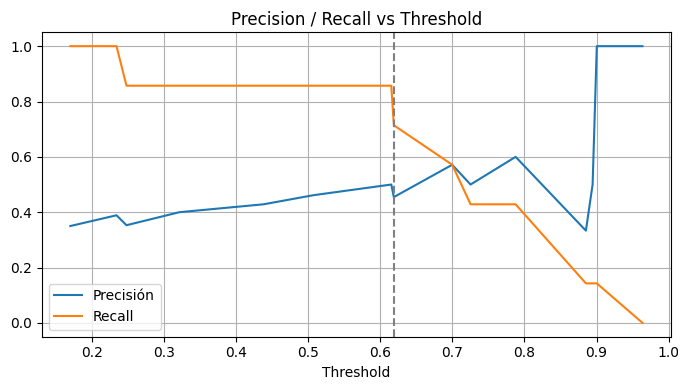

F1=0.632  Prec=0.500  Rec=0.857


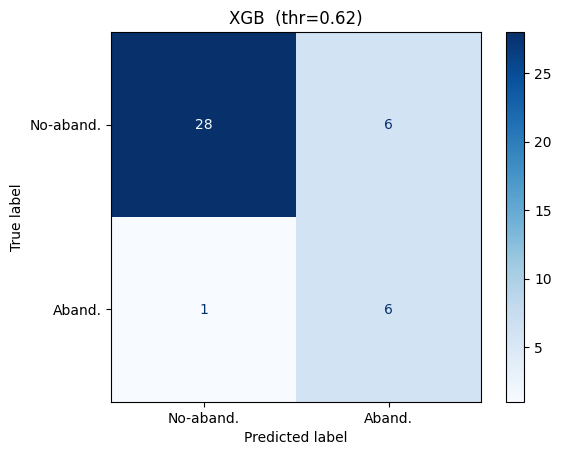

In [59]:
# Tomamos el *mejor* modelo según F1
best_name = max(metrics, key=lambda m: metrics[m]["f1"])
best_mdl  = models[best_name]
y_prob_te = best_mdl.predict_proba(X_te)[:,1]

precision, recall, thr = precision_recall_curve(y_te, y_prob_te)
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
best_thr = thr[np.argmax(f1_scores)]

print(f"▶ Mejor modelo: {best_name}  –  threshold óptimo ≈ {best_thr:.3f}")

# Curva P-R vs threshold
plt.figure(figsize=(7,4))
plt.plot(thr, precision[1:], label="Precisión")
plt.plot(thr, recall[1:]   , label="Recall")
plt.axvline(best_thr, ls="--", c="grey"); plt.legend()
plt.xlabel("Threshold"); plt.title("Precision / Recall vs Threshold")
plt.grid(True); plt.tight_layout(); plt.show()

# Métricas y matriz de confusión con nuevo umbral
y_pred_best = (y_prob_te >= best_thr).astype(int)
print(f"F1={f1_score(y_te,y_pred_best):.3f}  Prec={precision_score(y_te,y_pred_best):.3f}  Rec={recall_score(y_te,y_pred_best):.3f}")

cm = confusion_matrix(y_te, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["No-aband.","Aband."]).plot(cmap=plt.cm.Blues)
plt.title(f"{best_name}  (thr={best_thr:.2f})"); plt.show()
